# The Penniless Pilgrim

I came across this TED Ed video with a riddle (by [Dan Finkel](https://mathforlove.com/who-am-i/dan-finkel/)) on YouTube:

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/6sBB-gRhfjE" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

It's simple enough: you're a traveller, without a penny to your name. You enter a town with a simple grid-based street layout, like this:

In [2]:
import networkx as nx
from matplotlib import pyplot as plt
import sys

In [3]:
AA = 'ABCDE'
BB = '12345'

def make_graph():
    g = nx.Graph()
    g.add_nodes_from(a + b for a in AA for b in BB)
    g.add_edges_from(((a+b1, a+b2) for a in AA for (b1, b2) in zip(BB[:-1], BB[1:])), direction='EW')
    g.add_edges_from(((a1+b, a2+b) for (a1, a2) in zip(AA[:-1], AA[1:]) for b in BB), direction='NS')
    return g

g = make_graph()

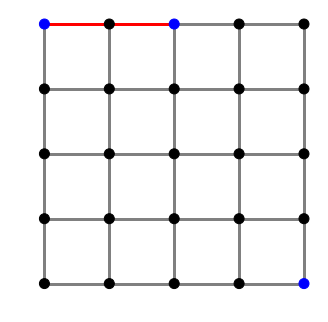

In [4]:
node_positions = {a+b: (j, len(AA) - i) for (i, a) in enumerate('ABCDE') for (j,b) in enumerate('12345')}

def draw_graph(g):
    plt.figure(figsize=(4,4))
    nx.draw(g, pos=node_positions,
               edge_color=['r' if g[u][v].get('trodden') else 'grey' for (u,v) in g.edges],
               width=3,
               node_size=100,
               node_color=['b' if n in ('A1', 'A3', 'E5') else 'k' for n in g.nodes])

g['A1']['A2']['trodden'] = True
g['A2']['A3']['trodden'] = True
    
draw_graph(g)

You enter the town at the north-west gate, and walk two blocks to the tourist information office. Your goal is to reach the temple at the far (south-east) corner of town. At the tourist information, you learn that the town has a curious system of tolls levied on all trips along the town's streets:

* Your trip through town is taxed based on the route you take.
* You are not allowed to use the same street twice in a trip, but you *are* allowed to cross an intersection multiple times.
* Walking one block from west to east increases your tax bill by 2 silver.
* Walking one from east to west decreases your bill by 2.
* Walking one from north to south doubles you tax bill.
* Walking one from south to north halves your tax bill.

As you've already walked to tourist information, two blocks east of the gate, you currently owe 4 silver. You want to get to the temple, and **you have no money**. Can you get to the temple without ending up in debtors' prison?

One of the more direct routes, going due south and turning east at the southern wall, would cost 68 silver. A lot more than you have!

I must admit that I didn't spend a lot of time trying to figure out a solution before giving up and watching the rest of the video, which gives a nice and elegant path that end up costing you nothing.

### Python to the rescue

After the fact, I couldn't help but wonder if there are other free routes to the temple. If so, how many? Are there any on which you *make* money?

Thankfully, this is fairly easy to brute force on a capable computer.

If we describe the town layout as a graph `g` using (way overpowered) `networkx`, edges being streets and nodes, labelled chessboard-style, being intersections, we mark the paths we've already taken as *“trodden”*

In [5]:
g['A1']['A2']['trodden'] = True
g['A2']['A3']['trodden'] = True

and without too much effort we can figure out where we *could* go next from our current position, and what that would cost us. Add a bit of housekeeping to produce a new graph for every route with the trodden streets properly marked,

In [6]:
def possible_steps(g, pos, cost):
    for dest, props in g[pos].items():
        if not props.get('trodden'):
            if props['direction'] == 'NS':
                new_cost = cost * 2 if dest[0] > pos[0] else cost / 2
            else:
                new_cost = cost + 2 if dest[1] > pos[1] else cost - 2
            new_g = g.copy()
            new_g[pos][dest]['trodden'] = True
            yield new_g, dest, new_cost

… and all we have to do is walk the graph!

I'll be doing this depth-first, as it were, as there's no easy way to discard partial routes that I can be bothered to think of.

In [7]:
def walk_on(g, steps, cost, dest=AA[-1]+BB[-1]):
    for next_g, next_step, next_cost in possible_steps(g, steps[-1], cost):
        new_steps = [*steps, next_step]
        if next_step == dest:
            yield (next_g, new_steps, next_cost)
        else:
            yield from walk_on(next_g, new_steps, next_cost)

This only takes about ten minutes on a single core of my aging PC. It should be easily parallelizable, but that's not for the here and now.

In [8]:
solutions = []
for solu in walk_on(g, ['A1', 'A2', 'A3'], 4):
    solutions.append(solu)
    sys.stdout.write(f'\r{len(solutions)}')
    sys.stdout.flush()
    
print(f'\n{len(solutions)} solutions found, min cost {min(c for g, s, c in solutions)}')
optima = [(g, s, c) for (g, s, c) in solutions if c <= 0]
print(f'{len(optima)} routes free or better')

58192
58192 solutions found, min cost -4.0
6 routes free or better


It turns out that of the 58192 allowed routes, we can afford a grand total of 6, some of which will, actually, give as a healthy tax refund of up to 4 shiny silver coins.

What do they look like (and are they correct)?

In [9]:
def explain_cost(steps):
    expl = ''
    g = make_graph()
    cost = 0
    for prev, step in zip(steps[:-1], steps[1:]):
        for new_g, next_step, new_cost in possible_steps(g, prev, cost):
            if next_step == step:
                g = new_g
                cost = new_cost
                break
        else:
            expl += 'ERROR\n'
            return expl
        expl += f'{prev} to {step} owing {cost}\n'
    return expl

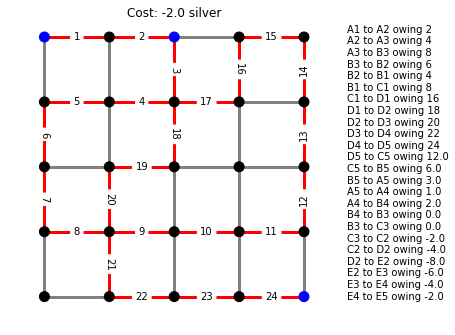

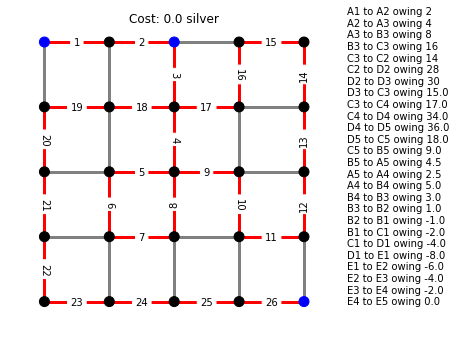

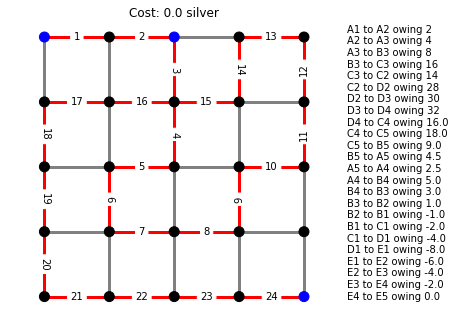

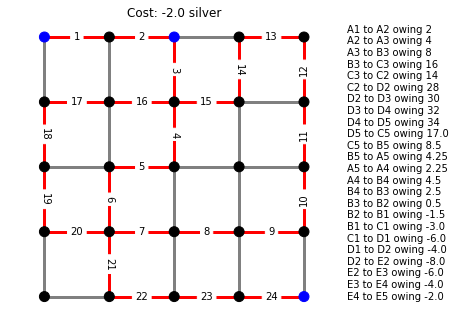

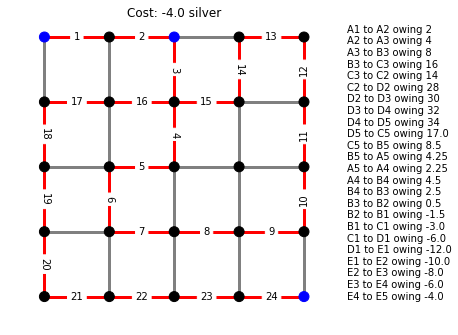

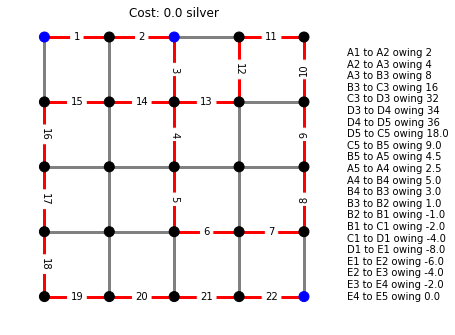

In [10]:
def draw_path(g, s, c):
    draw_graph(g)
    nx.draw_networkx_edge_labels(g, pos=node_positions,
        edge_labels={(u, v): str(i+1) for (i, (u,v)) in enumerate(zip(s[:-1], s[1:]))})
    plt.title(f'Cost: {c} silver')
    plt.figtext(1.1, 0, explain_cost(s))

for (g, s, c) in optima:
    draw_path(g, s, c)

Reassuringly, this found the canonical route:

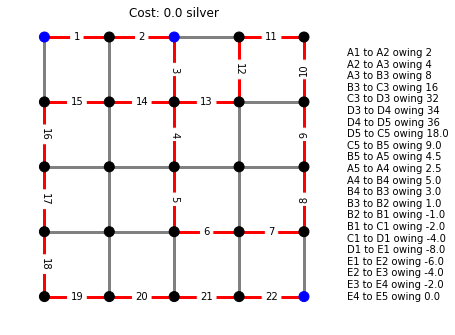

In [11]:
draw_path(*optima[5])

In [12]:
[len(s) for (g, s, c) in optima]

[25, 27, 25, 25, 25, 23]

This is, also, the shortest route we can afford. However, it's not the best. The best route involves a minor detour down the pub at C2:

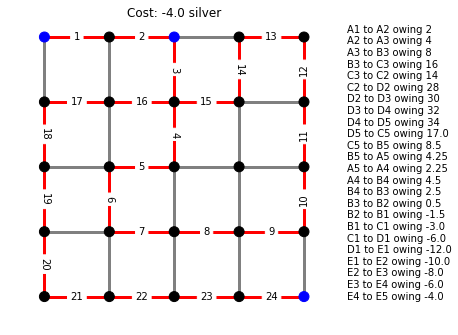

In [13]:
draw_path(*optima[4])